In [1]:
pip install pulp pandas numpy

Note: you may need to restart the kernel to use updated packages.


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mt/mgjpxf_n213bh1qtxs3w7kr40000gn/T/588ab29b00744a32ae6de7747b386347-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/mt/mgjpxf_n213bh1qtxs3w7kr40000gn/T/588ab29b00744a32ae6de7747b386347-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 60 COLUMNS
At line 206 RHS
At line 262 BOUNDS
At line 288 ENDATA
Problem MODEL has 55 rows, 55 columns and 90 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 78.112 - 0.00 seconds
Cgl0002I 15 variables fixed
Cgl0003I 1 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl000

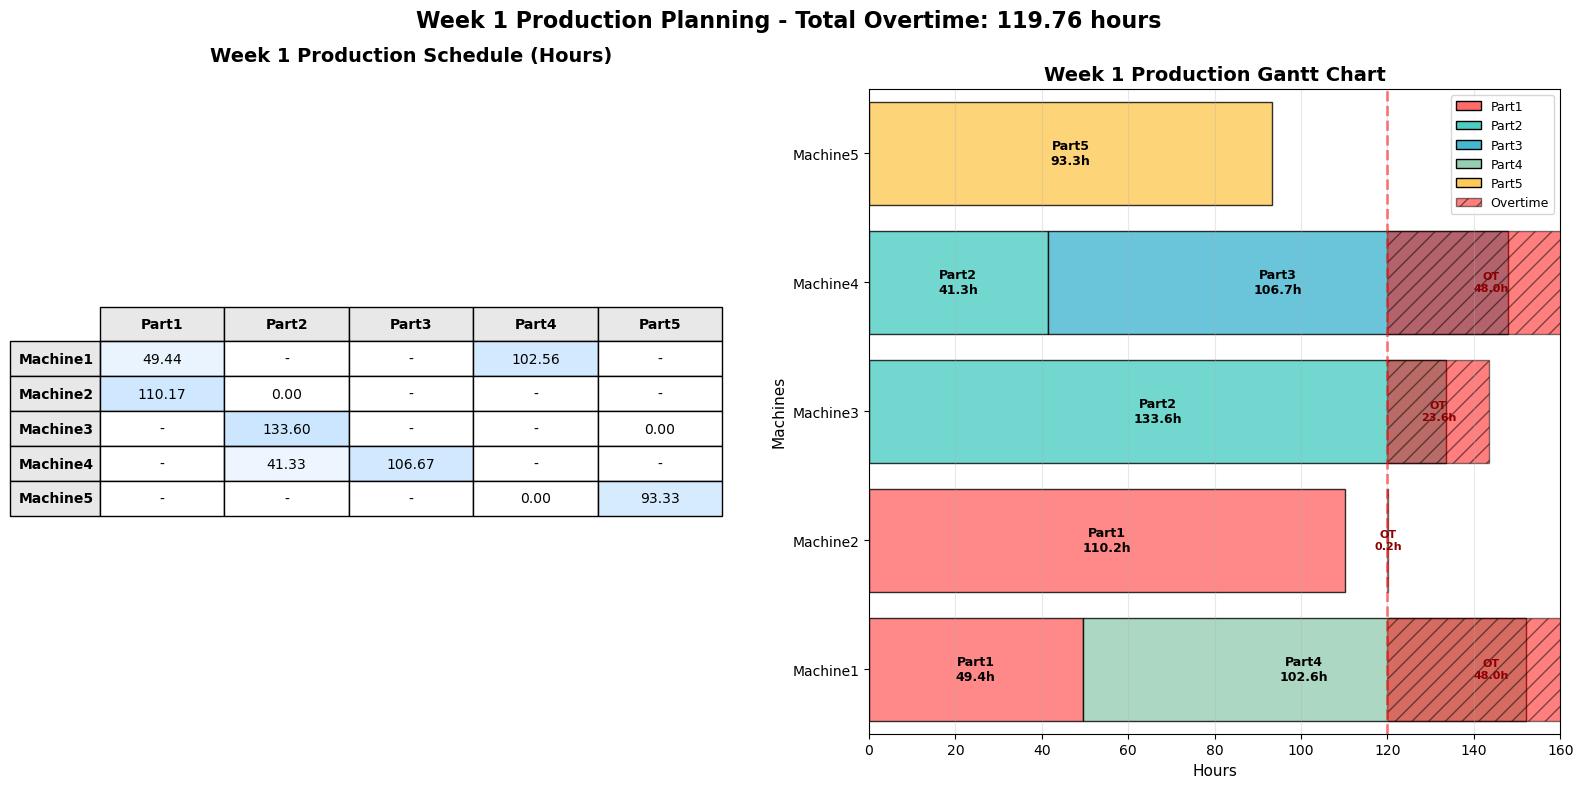

In [ ]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

# Loading data - Week 1 only
demand_week1 = [3500, 3000, 4000, 4000, 2800]  # Week 1 demand only

production_rates = {
    'Part1': [40, 35, None, None, None],
    'Part2': [None, 25, 30, 35, None],
    'Part3': [None, None, None, 50, None],
    'Part4': [60, None, None, None, 60],
    'Part5': [None, None, 45, None, 50]
}

rates_df = pd.DataFrame(production_rates, 
                        index=['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5'])

yields = [0.60, 0.55, 0.75, 0.65, 0.60]
yields_dict = dict(zip(['Part1', 'Part2', 'Part3', 'Part4', 'Part5'], yields))

setup_times_data = {
    'Part1': [8, 10, None, None, None],      # 8h on M1, 10h on M2
    'Part2': [None, 8, 10, 8, None],          # 8h on M2, 10h on M3, 8h on M4
    'Part3': [None, None, None, 12, None],    # 12h on M4 only
    'Part4': [8, None, None, None, 8],        # 8h on M1, 8h on M5
    'Part5': [None, None, 24, None, 20]       # 24h on M3, 20h on M5
}

setup_times_df = pd.DataFrame(setup_times_data, 
                              index=['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5'])


# Time constraint for week 1
weekly_time_limit = 120  # hours per week

# Big M constraint value
BIG_M = 168  # Maximum hours per week (7 days * 24 hours)

# Create the LP problem for Week 1 only
prob = pulp.LpProblem("Week1_Production_Planning", pulp.LpMinimize)

# Decision Variables
parts = ['Part1', 'Part2', 'Part3', 'Part4', 'Part5']
machines = ['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5']

# x_ij = hours of production time for part i on machine j in week 1
x = pulp.LpVariable.dicts("x", 
                          [(i, j) for i in parts for j in machines],
                          lowBound=0,
                          cat='Continuous')

# b_ij = binary variable (1 if part i is produced on machine j, 0 otherwise)
b = pulp.LpVariable.dicts("b",
                          [(i, j) for i in parts for j in machines],
                          cat='Binary')

# θ_j = overtime hours on machine j in week 1
theta = pulp.LpVariable.dicts("theta",
                              machines,
                              lowBound=0,
                              cat='Continuous')

# Objective Function: Minimize total overtime for week 1
prob += pulp.lpSum([theta[j] for j in machines]), "Week1_Total_Overtime"

# Constraints

# 1. Demand constraints for Week 1
for idx, part in enumerate(parts):
    valid_machines = []
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            valid_machines.append(machine)
    
    if valid_machines:
        # Production must meet Week 1 demand
        prob += pulp.lpSum([rates_df.loc[machine, part] * x[part, machine] * yields_dict[part] 
                            for machine in valid_machines]) >= demand_week1[idx], f"Week1_Demand_{part}"

# 2. Time constraints for each machine in Week 1
for machine in machines:
    time_components = []
    
    for part in parts:
        # Check if part can be produced on this machine (based on production rates)
        rate = rates_df.loc[machine, part]
        if pd.notna(rate):
            # Always add production time for valid part-machine combinations
            time_components.append(x[part, machine])
            
            # Add setup time only if it exists
            setup_time = setup_times_df.loc[machine, part]
            if pd.notna(setup_time):
                time_components.append(setup_time * b[part, machine])
    
    if time_components:
        # Constraint: total time <= 120 + overtime
        prob += pulp.lpSum(time_components) <= weekly_time_limit + theta[machine], f"Week1_Time_{machine}"

# Limit overtime to maximum 48 hours
for machine in machines:
    prob += theta[machine] <= 48, f"Week1_Max_Overtime_{machine}"

# 3. Big-M constraints for Week 1
for part in parts:
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            # If b = 1, then x can be positive; if b = 0, then x must be 0
            prob += x[part, machine] <= BIG_M * b[part, machine], f"Week1_BigM_{part}_{machine}_upper"
           # prob += x[part, machine] >= 0.001 * b[part, machine], f"Week1_BigM_{part}_{machine}_lower"
        else:
            # Part cannot be produced on this machine
            prob += x[part, machine] == 0, f"Week1_Cannot_produce_{part}_{machine}"
            prob += b[part, machine] == 0, f"Week1_Cannot_assign_{part}_{machine}"

# Solve the problem
prob.solve()

print("=" * 80)
print("WEEK 1 PRODUCTION PLANNING RESULTS")
print("=" * 80)
print(f"\nStatus: {pulp.LpStatus[prob.status]}")
print(f"Total Overtime Hours for Week 1: {pulp.value(prob.objective):.2f} hours")

# Create production schedule table for Week 1
schedule = pd.DataFrame(index=machines, columns=parts)
for part in parts:
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            value = pulp.value(x[part, machine])
            if value is not None and value > 0.001:
                schedule.loc[machine, part] = round(value, 2)
            else:
                schedule.loc[machine, part] = 0
        else:
            schedule.loc[machine, part] = None

print("\n--- WEEK 1 PRODUCTION SCHEDULE (HOURS) ---")
display_schedule = schedule.copy()
for col in display_schedule.columns:
    display_schedule[col] = display_schedule[col].apply(
        lambda x: f"{x:.2f}" if pd.notna(x) and x > 0 else ("-" if pd.isna(x) else "0.00")
    )
print(display_schedule.to_string())

# Overtime hours
print("\n--- WEEK 1 OVERTIME HOURS ---")
overtime_data = {}
for machine in machines:
    overtime = pulp.value(theta[machine])
    overtime_data[machine] = round(overtime, 2) if overtime > 0.001 else 0
overtime_df = pd.DataFrame([overtime_data], index=['Overtime'])
print(overtime_df.to_string())

# Production quantities and demand satisfaction
print("\n--- WEEK 1 PRODUCTION QUANTITIES ---")
production_summary = []
for idx, part in enumerate(parts):
    total_produced = 0
    machine_breakdown = []
    
    for machine in machines:
        hours = schedule.loc[machine, part]
        if hours is not None and hours > 0:
            rate = rates_df.loc[machine, part]
            quantity = hours * rate * yields_dict[part]
            total_produced += quantity
            machine_breakdown.append(f"{machine}: {hours:.2f}h × {rate}u/h × {yields_dict[part]:.0%} = {quantity:.0f}u")
    
    demand = demand_week1[idx]
    deficit = demand - total_produced
    
    print(f"\n{part}:")
    print(f"  Demand: {demand} units")
    print(f"  Total Produced: {total_produced:.0f} units")
    
    if deficit <= 1.0:  # 1 unit tolerance for floating-point
        print(f"  Status: ✓ Demand satisfied (surplus: {max(0, -deficit):.0f} units)")
    else:
        print(f"  Status: ✗ Demand NOT met (deficit: {deficit:.0f} units)")
    
    if machine_breakdown:
        print("  Production breakdown:")
        for breakdown in machine_breakdown:
            print(f"    {breakdown}")
    
    production_summary.append({
        'Part': part,
        'Demand': demand,
        'Produced': round(total_produced),
        'Surplus/Deficit': round(total_produced - demand),
        'Status': '✓' if deficit <= 1.0 else '✗'
    })

# Summary table
print("\n--- WEEK 1 PRODUCTION vs DEMAND SUMMARY ---")
summary_df = pd.DataFrame(production_summary)
print(summary_df.to_string(index=False))

# Machine utilization
print("\n--- WEEK 1 MACHINE UTILIZATION ---")
utilization_data = []
for machine in machines:
    total_hours = sum(schedule.loc[machine, part] 
                     for part in parts 
                     if schedule.loc[machine, part] is not None)
    available_hours = weekly_time_limit + overtime_data[machine]
    utilization = (total_hours / available_hours * 100) if available_hours > 0 else 0
    
    utilization_data.append({
        'Machine': machine,
        'Hours Used': f"{total_hours:.2f}",
        'Hours Available': f"{available_hours:.2f}",
        'Utilization': f"{utilization:.1f}%",
        'Overtime': f"{overtime_data[machine]:.2f}"
    })

util_df = pd.DataFrame(utilization_data)
print(util_df.to_string(index=False))

# Create visualization for Week 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Color palette for parts
part_colors = {
    'Part1': '#FF6B6B',
    'Part2': '#4ECDC4',
    'Part3': '#45B7D1',
    'Part4': '#96CEB4',
    'Part5': '#FECA57'
}

# 1. Production Schedule Heatmap
ax1.axis('tight')
ax1.axis('off')

# Create table data for visualization
table_data = display_schedule.values
table = ax1.table(cellText=table_data,
                  rowLabels=display_schedule.index,
                  colLabels=display_schedule.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15]*len(parts))

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Color cells based on production
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor('#E8E8E8')
        cell.set_text_props(weight='bold')
    elif j == -1:  # Row labels
        cell.set_facecolor('#E8E8E8')
        cell.set_text_props(weight='bold')
    elif i > 0 and j >= 0:
        value_str = table_data[i-1][j]
        if value_str != '-' and float(value_str) > 0:
            # Color intensity based on hours
            intensity = min(float(value_str) / 120, 1)  # Normalize to 0-1
            cell.set_facecolor((0.8, 0.9, 1.0, intensity))

ax1.set_title('Week 1 Production Schedule (Hours)', fontsize=14, fontweight='bold', pad=20)

# 2. Gantt Chart
y_pos = 0
y_labels = []
y_ticks = []

for machine in machines:
    start_time = 0
    machine_used = False
    
    for part in parts:
        hours = schedule.loc[machine, part]
        if hours is not None and hours > 0:
            # Draw production block
            rect = Rectangle((start_time, y_pos - 0.4), hours, 0.8,
                           facecolor=part_colors[part],
                           edgecolor='black',
                           linewidth=1,
                           alpha=0.8)
            ax2.add_patch(rect)
            
            # Add label if block is wide enough
            if hours > 10:
                ax2.text(start_time + hours/2, y_pos,
                        f'{part}\n{hours:.1f}h',
                        ha='center', va='center',
                        fontsize=9, fontweight='bold')
            elif hours > 5:
                ax2.text(start_time + hours/2, y_pos,
                        f'{hours:.1f}h',
                        ha='center', va='center',
                        fontsize=8)
            
            start_time += hours
            machine_used = True
    
    # Add overtime if any
    if overtime_data[machine] > 0:
        rect = Rectangle((120, y_pos - 0.4), overtime_data[machine], 0.8,
                       facecolor='red',
                       edgecolor='black',
                       linewidth=1,
                       alpha=0.5,
                       hatch='//')
        ax2.add_patch(rect)
        ax2.text(120 + overtime_data[machine]/2, y_pos,
                f'OT\n{overtime_data[machine]:.1f}h',
                ha='center', va='center',
                fontsize=8, color='darkred', fontweight='bold')
    
    if machine_used or overtime_data[machine] > 0:
        y_labels.append(machine)
        y_ticks.append(y_pos)
        y_pos += 1

# Format Gantt chart
ax2.set_xlim(0, 160)
ax2.set_ylim(-0.5, y_pos - 0.5)
ax2.set_xlabel('Hours', fontsize=11)
ax2.set_ylabel('Machines', fontsize=11)
ax2.set_title('Week 1 Production Gantt Chart', fontsize=14, fontweight='bold')

# Add vertical line at 120 hours
ax2.axvline(x=120, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Regular Time Limit (120h)')

ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_labels)
ax2.grid(True, axis='x', alpha=0.3)

# Add legend
legend_elements = [patches.Patch(facecolor=color, edgecolor='black', label=part)
                  for part, color in part_colors.items()]
legend_elements.append(patches.Patch(facecolor='red', alpha=0.5,
                                    edgecolor='black', label='Overtime', hatch='//'))
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.suptitle(f'Week 1 Production Planning - Total Overtime: {pulp.value(prob.objective):.2f} hours',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mt/mgjpxf_n213bh1qtxs3w7kr40000gn/T/15f701853d57454ab2d5c32adaa727a9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/mt/mgjpxf_n213bh1qtxs3w7kr40000gn/T/15f701853d57454ab2d5c32adaa727a9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 60 COLUMNS
At line 206 RHS
At line 262 BOUNDS
At line 288 ENDATA
Problem MODEL has 55 rows, 55 columns and 90 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 78.112 - 0.00 seconds
Cgl0002I 15 variables fixed
Cgl0003I 1 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl000

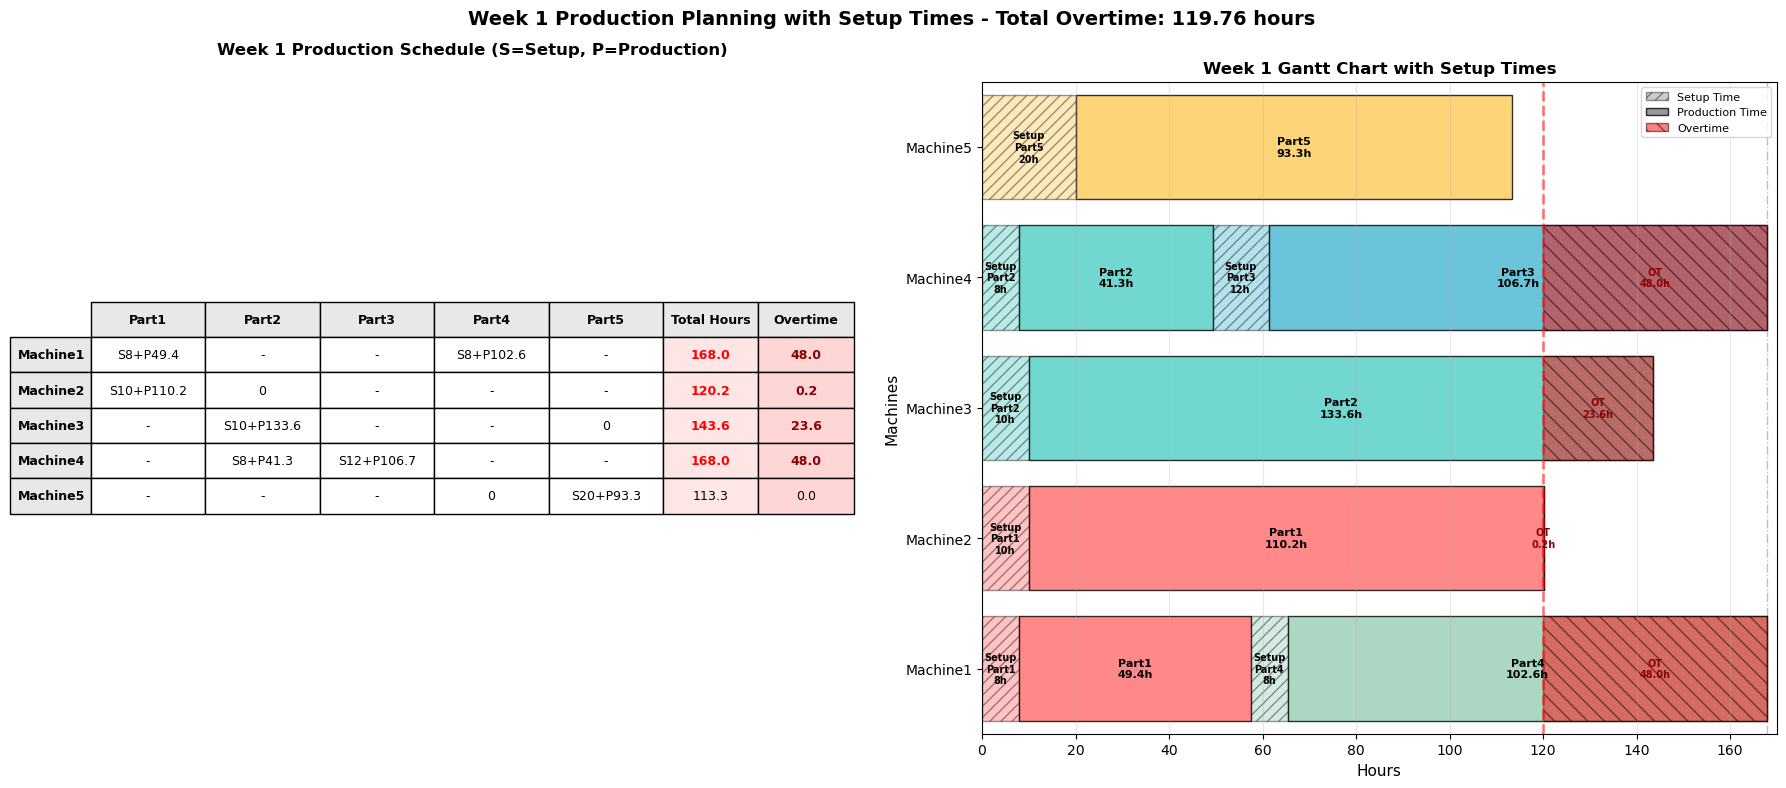


WEEK 1 OPTIMIZATION COMPLETE


In [ ]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

# Loading data - Week 1 only
demand_week1 = [3500, 3000, 4000, 4000, 2800]  # Week 1 demand only

production_rates = {
    'Part1': [40, 35, None, None, None],
    'Part2': [None, 25, 30, 35, None],
    'Part3': [None, None, None, 50, None],
    'Part4': [60, None, None, None, 60],
    'Part5': [None, None, 45, None, 50]
}

rates_df = pd.DataFrame(production_rates, 
                        index=['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5'])

yields = [0.60, 0.55, 0.75, 0.65, 0.60]
yields_dict = dict(zip(['Part1', 'Part2', 'Part3', 'Part4', 'Part5'], yields))

setup_times_data = {
    'Part1': [8, 10, None, None, None],      # 8h on M1, 10h on M2
    'Part2': [None, 8, 10, 8, None],          # 8h on M2, 10h on M3, 8h on M4
    'Part3': [None, None, None, 12, None],    # 12h on M4 only
    'Part4': [8, None, None, None, 8],        # 8h on M1, 8h on M5
    'Part5': [None, None, 24, None, 20]       # 24h on M3, 20h on M5
}

setup_times_df = pd.DataFrame(setup_times_data, 
                              index=['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5'])

# Time constraint for week 1
weekly_time_limit = 120  # hours per week

# Big M constraint value
BIG_M = 168  # Maximum hours per week (7 days * 24 hours)

# Create the LP problem for Week 1 only
prob = pulp.LpProblem("Week1_Production_Planning", pulp.LpMinimize)

# Decision Variables
parts = ['Part1', 'Part2', 'Part3', 'Part4', 'Part5']
machines = ['Machine1', 'Machine2', 'Machine3', 'Machine4', 'Machine5']

# x_ij = hours of production time for part i on machine j in week 1
x = pulp.LpVariable.dicts("x", 
                          [(i, j) for i in parts for j in machines],
                          lowBound=0,
                          cat='Continuous')

# b_ij = binary variable (1 if part i is produced on machine j, 0 otherwise)
b = pulp.LpVariable.dicts("b",
                          [(i, j) for i in parts for j in machines],
                          cat='Binary')

# θ_j = overtime hours on machine j in week 1
theta = pulp.LpVariable.dicts("theta",
                              machines,
                              lowBound=0,
                              cat='Continuous')

# Objective Function: Minimize total overtime for week 1
prob += pulp.lpSum([theta[j] for j in machines]), "Week1_Total_Overtime"

# Constraints

# 1. Demand constraints for Week 1
for idx, part in enumerate(parts):
    valid_machines = []
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            valid_machines.append(machine)
    
    if valid_machines:
        # Production must meet Week 1 demand
        prob += pulp.lpSum([rates_df.loc[machine, part] * x[part, machine] * yields_dict[part] 
                            for machine in valid_machines]) >= demand_week1[idx], f"Week1_Demand_{part}"

# 2. Time constraints for each machine in Week 1 (CORRECTED)
for machine in machines:
    time_components = []
    
    for part in parts:
        # Check if part can be produced on this machine (based on production rates)
        rate = rates_df.loc[machine, part]
        if pd.notna(rate):
            # Always add production time for valid part-machine combinations
            time_components.append(x[part, machine])
            
            # Add setup time only if it exists
            setup_time = setup_times_df.loc[machine, part]
            if pd.notna(setup_time):
                time_components.append(setup_time * b[part, machine])
    
    if time_components:
        # Constraint: total time <= 120 + overtime
        prob += pulp.lpSum(time_components) <= weekly_time_limit + theta[machine], f"Week1_Time_{machine}"

#Limit overtime to maximum 48 hours
for machine in machines:
    prob += theta[machine] <= 48, f"Week1_Max_Overtime_{machine}"

# 3. Big-M constraints for Week 1
for part in parts:
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            # If b = 1, then x can be positive; if b = 0, then x must be 0
            prob += x[part, machine] <= BIG_M * b[part, machine], f"Week1_BigM_{part}_{machine}_upper"
            # prob += x[part, machine] >= 0.001 * b[part, machine], f"Week1_BigM_{part}_{machine}_lower"
        else:
            # Part cannot be produced on this machine
            prob += x[part, machine] == 0, f"Week1_Cannot_produce_{part}_{machine}"
            prob += b[part, machine] == 0, f"Week1_Cannot_assign_{part}_{machine}"

# Solve the problem
prob.solve()

print("=" * 80)
print("WEEK 1 PRODUCTION PLANNING RESULTS")
print("=" * 80)
print(f"\nStatus: {pulp.LpStatus[prob.status]}")
print(f"Total Overtime Hours for Week 1: {pulp.value(prob.objective):.2f} hours")

# Create production schedule table for Week 1
schedule = pd.DataFrame(index=machines, columns=parts)
binary_schedule = pd.DataFrame(index=machines, columns=parts)

for part in parts:
    for machine in machines:
        rate = rates_df.loc[machine, part]
        if rate is not None and pd.notna(rate):
            value = pulp.value(x[part, machine])
            b_value = pulp.value(b[part, machine])
            if value is not None and value > 0.001:
                schedule.loc[machine, part] = round(value, 2)
                binary_schedule.loc[machine, part] = 1 if b_value > 0.5 else 0
            else:
                schedule.loc[machine, part] = 0
                binary_schedule.loc[machine, part] = 0
        else:
            schedule.loc[machine, part] = None
            binary_schedule.loc[machine, part] = None

print("\n--- WEEK 1 PRODUCTION SCHEDULE (HOURS) ---")
display_schedule = schedule.copy()
for col in display_schedule.columns:
    display_schedule[col] = display_schedule[col].apply(
        lambda x: f"{x:.2f}" if pd.notna(x) and x > 0 else ("-" if pd.isna(x) else "0.00")
    )
print(display_schedule.to_string())

# Overtime hours
print("\n--- WEEK 1 OVERTIME HOURS ---")
overtime_data = {}
for machine in machines:
    overtime = pulp.value(theta[machine])
    overtime_data[machine] = round(overtime, 2) if overtime > 0.001 else 0
overtime_df = pd.DataFrame([overtime_data], index=['Overtime'])
print(overtime_df.to_string())

# Production quantities and demand satisfaction
print("\n--- WEEK 1 PRODUCTION QUANTITIES ---")
production_summary = []
for idx, part in enumerate(parts):
    total_produced = 0
    machine_breakdown = []
    
    for machine in machines:
        hours = schedule.loc[machine, part]
        setup_time = setup_times_df.loc[machine, part]
        is_produced = binary_schedule.loc[machine, part]
        
        if hours is not None and hours > 0:
            rate = rates_df.loc[machine, part]
            quantity = hours * rate * yields_dict[part]
            total_produced += quantity
            
            # Include setup time in breakdown if applicable
            if pd.notna(setup_time) and is_produced == 1:
                machine_breakdown.append(
                    f"{machine}: Setup={setup_time:.0f}h, Prod={hours:.2f}h × {rate}u/h × {yields_dict[part]:.0%} = {quantity:.0f}u"
                )
            else:
                machine_breakdown.append(
                    f"{machine}: {hours:.2f}h × {rate}u/h × {yields_dict[part]:.0%} = {quantity:.0f}u"
                )
    
    demand = demand_week1[idx]
    deficit = demand - total_produced
    
    print(f"\n{part}:")
    print(f"  Demand: {demand} units")
    print(f"  Total Produced: {total_produced:.0f} units")
    
    if deficit <= 1.0:  # 1 unit tolerance for floating-point
        print(f"  Status: ✓ Demand satisfied (surplus: {max(0, -deficit):.0f} units)")
    else:
        print(f"  Status: ✗ Demand NOT met (deficit: {deficit:.0f} units)")
    
    if machine_breakdown:
        print("  Production breakdown:")
        for breakdown in machine_breakdown:
            print(f"    {breakdown}")
    
    production_summary.append({
        'Part': part,
        'Demand': demand,
        'Produced': round(total_produced),
        'Surplus/Deficit': round(total_produced - demand),
        'Status': '✓' if deficit <= 1.0 else '✗'
    })

# Summary table
print("\n--- WEEK 1 PRODUCTION vs DEMAND SUMMARY ---")
summary_df = pd.DataFrame(production_summary)
print(summary_df.to_string(index=False))

# Enhanced Machine utilization with setup time breakdown
print("\n--- WEEK 1 MACHINE UTILIZATION WITH SETUP BREAKDOWN ---")
utilization_data = []

for machine in machines:
    total_setup = 0
    total_production = 0
    
    # Calculate setup and production hours
    for part in parts:
        setup_time = setup_times_df.loc[machine, part]
        prod_hours = schedule.loc[machine, part]
        is_produced = binary_schedule.loc[machine, part]
        
        if pd.notna(setup_time) and prod_hours is not None and is_produced == 1:
            total_setup += setup_time
            total_production += prod_hours
        elif prod_hours is not None and prod_hours > 0:
            total_production += prod_hours
    
    total_hours = total_setup + total_production
    available_hours = weekly_time_limit + overtime_data[machine]
    utilization = (total_hours / available_hours * 100) if available_hours > 0 else 0
    
    utilization_data.append({
        'Machine': machine,
        'Setup Hours': f"{total_setup:.0f}",
        'Prod Hours': f"{total_production:.2f}",
        'Total Hours': f"{total_hours:.2f}",
        'Regular (120h)': "120",
        'Overtime': f"{overtime_data[machine]:.2f}",
        'Available': f"{available_hours:.2f}",
        'Utilization': f"{utilization:.1f}%"
    })

util_df = pd.DataFrame(utilization_data)
print(util_df.to_string(index=False))

# Create enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Color palette for parts
part_colors = {
    'Part1': '#FF6B6B',
    'Part2': '#4ECDC4',
    'Part3': '#45B7D1',
    'Part4': '#96CEB4',
    'Part5': '#FECA57'
}

# 1. Enhanced Production Schedule Table with Total Hours
ax1.axis('tight')
ax1.axis('off')

# Create enhanced table data with total hours column
table_rows = []
for machine in machines:
    row = []
    total_setup = 0
    total_prod = 0
    
    for part in parts:
        setup_time = setup_times_df.loc[machine, part]
        prod_hours = schedule.loc[machine, part]
        is_produced = binary_schedule.loc[machine, part]
        
        if pd.notna(setup_time) and prod_hours is not None and is_produced == 1 and prod_hours > 0:
            row.append(f"S{setup_time:.0f}+P{prod_hours:.1f}")
            total_setup += setup_time
            total_prod += prod_hours
        elif prod_hours is not None and prod_hours > 0:
            row.append(f"P{prod_hours:.1f}")
            total_prod += prod_hours
        elif pd.notna(setup_time) or pd.notna(rates_df.loc[machine, part]):
            row.append("0")
        else:
            row.append("-")
    
    # Add total hours and overtime columns
    total = total_setup + total_prod
    row.append(f"{total:.1f}")
    row.append(f"{overtime_data[machine]:.1f}")
    table_rows.append(row)

# Create column labels with Total and OT
col_labels = list(parts) + ['Total Hours', 'Overtime']

table = ax1.table(cellText=table_rows,
                  rowLabels=machines,
                  colLabels=col_labels,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.12]*len(parts) + [0.1, 0.1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 2)

# Color cells
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor('#E8E8E8')
        cell.set_text_props(weight='bold')
    elif j == -1:  # Row labels
        cell.set_facecolor('#E8E8E8')
        cell.set_text_props(weight='bold')
    elif j == len(parts):  # Total hours column
        cell.set_facecolor('#FFE6E6')
        if i > 0:
            total_val = float(table_rows[i-1][-2])
            if total_val > 120:  # Highlight if overtime needed
                cell.set_text_props(weight='bold', color='red')
    elif j == len(parts) + 1:  # Overtime column
        cell.set_facecolor('#FFD6D6')
        if i > 0:
            ot_val = float(table_rows[i-1][-1])
            if ot_val > 0:  # Highlight if overtime used
                cell.set_text_props(weight='bold', color='darkred')

ax1.set_title('Week 1 Production Schedule (S=Setup, P=Production)', 
              fontsize=12, fontweight='bold', pad=20)

# 2. Enhanced Gantt Chart with Setup Times
ax2.set_title('Week 1 Gantt Chart with Setup Times', fontsize=12, fontweight='bold')
y_pos = 0
y_labels = []
y_ticks = []

for machine in machines:
    start_time = 0
    machine_used = False
    
    for part in parts:
        setup_time = setup_times_df.loc[machine, part]
        prod_hours = schedule.loc[machine, part]
        is_produced = binary_schedule.loc[machine, part]
        
        if pd.notna(setup_time) and prod_hours is not None and is_produced == 1 and prod_hours > 0:
            # Draw setup time block (hatched pattern)
            setup_rect = Rectangle((start_time, y_pos - 0.4), setup_time, 0.8,
                                  facecolor=part_colors[part], 
                                  edgecolor='black',
                                  linewidth=1,
                                  alpha=0.4,
                                  hatch='///')
            ax2.add_patch(setup_rect)
            
            # Label setup block if wide enough
            if setup_time > 4:
                ax2.text(start_time + setup_time/2, y_pos,
                        f'Setup\n{part}\n{setup_time:.0f}h',
                        ha='center', va='center',
                        fontsize=7, fontweight='bold')
            else:
                ax2.text(start_time + setup_time/2, y_pos,
                        f'S{setup_time:.0f}',
                        ha='center', va='center',
                        fontsize=6)
            
            start_time += setup_time
            
            # Draw production block (solid color)
            prod_rect = Rectangle((start_time, y_pos - 0.4), prod_hours, 0.8,
                                 facecolor=part_colors[part],
                                 edgecolor='black',
                                 linewidth=1,
                                 alpha=0.8)
            ax2.add_patch(prod_rect)
            
            # Label production block
            if prod_hours > 10:
                ax2.text(start_time + prod_hours/2, y_pos,
                        f'{part}\n{prod_hours:.1f}h',
                        ha='center', va='center',
                        fontsize=8, fontweight='bold')
            elif prod_hours > 5:
                ax2.text(start_time + prod_hours/2, y_pos,
                        f'{prod_hours:.1f}h',
                        ha='center', va='center',
                        fontsize=7)
            
            start_time += prod_hours
            machine_used = True
            
        elif prod_hours is not None and prod_hours > 0:
            # No setup time, just production
            prod_rect = Rectangle((start_time, y_pos - 0.4), prod_hours, 0.8,
                                 facecolor=part_colors[part],
                                 edgecolor='black',
                                 linewidth=1,
                                 alpha=0.8)
            ax2.add_patch(prod_rect)
            
            if prod_hours > 10:
                ax2.text(start_time + prod_hours/2, y_pos,
                        f'{part}\n{prod_hours:.1f}h',
                        ha='center', va='center',
                        fontsize=8, fontweight='bold')
            elif prod_hours > 5:
                ax2.text(start_time + prod_hours/2, y_pos,
                        f'{prod_hours:.1f}h',
                        ha='center', va='center',
                        fontsize=7)
            
            start_time += prod_hours
            machine_used = True
    
    # Add overtime block if any
    if overtime_data[machine] > 0:
        ot_rect = Rectangle((120, y_pos - 0.4), overtime_data[machine], 0.8,
                           facecolor='red',
                           edgecolor='black',
                           linewidth=1,
                           alpha=0.5,
                           hatch='\\\\')
        ax2.add_patch(ot_rect)
        ax2.text(120 + overtime_data[machine]/2, y_pos,
                f'OT\n{overtime_data[machine]:.1f}h',
                ha='center', va='center',
                fontsize=7, color='darkred', fontweight='bold')
    
    if machine_used or overtime_data[machine] > 0:
        y_labels.append(machine)
        y_ticks.append(y_pos)
        y_pos += 1

# Format Gantt chart
ax2.set_xlim(0, 170)
ax2.set_ylim(-0.5, y_pos - 0.5)
ax2.set_xlabel('Hours', fontsize=11)
ax2.set_ylabel('Machines', fontsize=11)

# Add vertical line at 120 hours (regular time limit)
ax2.axvline(x=120, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Regular Time (120h)')
# Add vertical line at 168 hours (absolute maximum)
ax2.axvline(x=168, color='darkred', linestyle='-.', alpha=0.3, linewidth=1, label='Max Possible (168h)')

ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_labels)
ax2.grid(True, axis='x', alpha=0.3)

# Enhanced legend
legend_elements = [
    patches.Patch(facecolor='gray', alpha=0.4, hatch='///', 
                  edgecolor='black', label='Setup Time'),
    patches.Patch(facecolor='gray', alpha=0.8, 
                  edgecolor='black', label='Production Time'),
    patches.Patch(facecolor='red', alpha=0.5, hatch='\\\\', 
                  edgecolor='black', label='Overtime')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.suptitle(f'Week 1 Production Planning with Setup Times - Total Overtime: {pulp.value(prob.objective):.2f} hours',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("WEEK 1 OPTIMIZATION COMPLETE")
print("=" * 80)